In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import joblib

# -------------------------------
# ✅ Load & clean data
# -------------------------------
data = pd.read_csv("C:\Users\tvtej\Downloads\employee-salary-prediction-ml\data\employee_salary_dataset.csv")

data['occupation'] = data['occupation'].replace({'?': 'Others'})
data['workclass'] = data['workclass'].replace({'?': 'NotListed'})
data['native-country'] = data['native-country'].replace({'?': 'Others'})

data = data[~data['workclass'].isin(['Without-pay', 'Never-worked'])]
data = data[data['occupation'] != 'Armed-Forces']
data = data[data['marital-status'] != 'Married-AF-spouse']
data = data[data['education'] != 'Preschool']
data = data[data['native-country'] != 'Holand-Netherlands']

data.drop(columns=['education'], inplace=True)

data = data[(data['age'] <= 75) & (data['age'] >= 17)]
data = data[(data['educational-num'] <= 16) & (data['educational-num'] >= 5)]
data = data[(data['hours-per-week'] <= 50) & (data['hours-per-week'] >= 35)]

# -------------------------------
# ✅ Define X, y
# -------------------------------
X = data.drop(columns=['income'])
y = data['income']

categorical_cols = [
    'workclass', 'marital-status', 'occupation',
    'relationship', 'race', 'gender', 'native-country'
]
numeric_cols = [
    'age', 'fnlwgt', 'educational-num',
    'capital-gain', 'capital-loss', 'hours-per-week'
]

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "GradientBoosting": GradientBoostingClassifier()
}

results = {}
pipelines = {}

for name, clf in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    pipelines[name] = pipe
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

best_model_name = max(results, key=results.get)
best_pipeline = pipelines[best_model_name]

print(f"\n✅ Best Model: {best_model_name} with Accuracy: {results[best_model_name]:.4f}")

joblib.dump(best_pipeline, "best_model.pkl")
print("✅ Saved best pipeline as best_model.pkl")


Categorical columns: ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
Numeric columns: ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

LogisticRegression Accuracy: 0.8403
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.90      5014
        >50K       0.72      0.60      0.66      1706

    accuracy                           0.84      6720
   macro avg       0.80      0.76      0.78      6720
weighted avg       0.83      0.84      0.84      6720


RandomForest Accuracy: 0.8426
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      5014
        >50K       0.72      0.61      0.66      1706

    accuracy                           0.84      6720
   macro avg       0.80      0.77      0.78      6720
weighted avg       0.84      0.84      0.84      6720


KNN Accuracy: 0.8179
              precision    recall

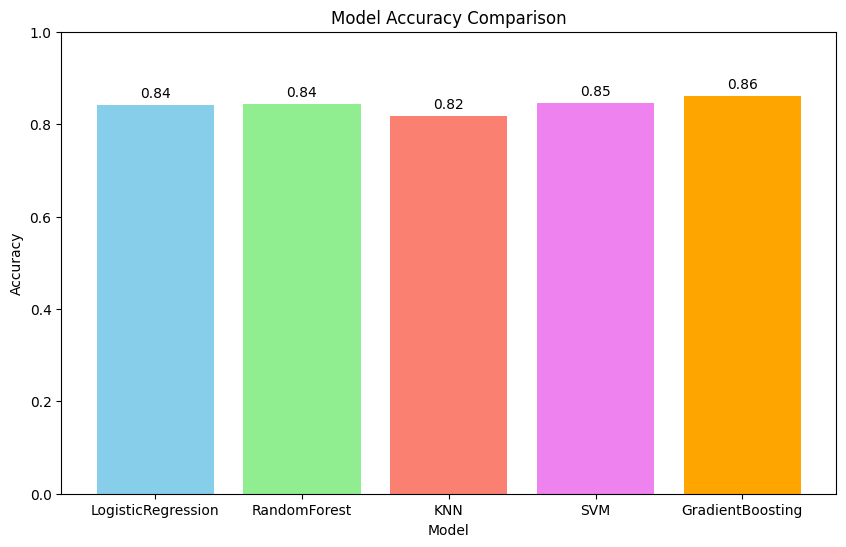

In [ ]:
import matplotlib.pyplot as plt

# After calculating 'results', plot the bar chart
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'violet', 'orange'])

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{acc:.2f}", ha='center', va='bottom')

plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.show()


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

st.set_page_config(
    page_title="Employee Salary Predictor",
    page_icon="💼",
    layout="centered"
)

@st.cache_resource
def load_model(path="best_model.pkl"):
    return joblib.load(path)

model = load_model()

st.title("💼 Predict Employee Salary Bracket")
st.write(
    """
    Enter employee details below to predict whether their salary exceeds \$50K annually.
    """
)

with st.form("employee_input_form"):
    st.header("🧾 Employee Information")

    col1, col2 = st.columns(2)

    with col1:
        age = st.slider("Age", 18, 75, 30)
        fnlwgt = st.number_input("Final Weight (fnlwgt)", min_value=0, value=100000)
        educational_num = st.slider("Education Num (5–16)", 5, 16, 10)
        capital_gain = st.number_input("Capital Gain", min_value=0, value=0)
        capital_loss = st.number_input("Capital Loss", min_value=0, value=0)
        hours_per_week = st.slider("Hours worked per week", 35, 50, 40)

    with col2:
        workclass = st.selectbox(
            "Workclass",
            ["Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov",
             "Local-gov", "State-gov", "NotListed"]
        )
        marital_status = st.selectbox(
            "Marital Status",
            ["Never-married", "Married-civ-spouse", "Divorced", "Separated", "Widowed"]
        )
        occupation = st.selectbox(
            "Occupation",
            [
                "Tech-support", "Craft-repair", "Other-service", "Sales",
                "Exec-managerial", "Prof-specialty", "Handlers-cleaners",
                "Machine-op-inspct", "Adm-clerical", "Farming-fishing",
                "Transport-moving", "Priv-house-serv", "Protective-serv",
                "Others"
            ]
        )
        relationship = st.selectbox(
            "Relationship",
            ["Husband", "Not-in-family", "Own-child", "Unmarried", "Other-relative"]
        )
        race = st.selectbox(
            "Race",
            ["White", "Black", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other"]
        )
        gender = st.radio("Gender", ["Male", "Female"])
        native_country = st.selectbox(
            "Native Country",
            ["United-States", "Mexico", "Philippines", "Germany", "Canada", "Others"]
        )

    submitted = st.form_submit_button("🔍 Predict")

if submitted:
    features = pd.DataFrame({
        "age": [age],
        "workclass": [workclass],
        "fnlwgt": [fnlwgt],
        "marital-status": [marital_status],
        "occupation": [occupation],
        "relationship": [relationship],
        "race": [race],
        "gender": [gender],
        "native-country": [native_country],
        "educational-num": [educational_num],
        "capital-gain": [capital_gain],
        "capital-loss": [capital_loss],
        "hours-per-week": [hours_per_week]
    })

    st.write("### ✅ Input Preview")
    st.dataframe(features)

    prediction = model.predict(features)
    st.success(f"**Result:** The model predicts this employee earns **{prediction[0]}**.")

st.divider()
st.header("📂 Bulk Prediction")

csv_file = st.file_uploader(
    "Upload a CSV with the same columns as above (EXACT!).",
    type="csv"
)

if csv_file:
    try:
        batch_df = pd.read_csv(csv_file)
        st.write("Sample of uploaded data:", batch_df.head())

        batch_predictions = model.predict(batch_df)
        batch_df["SalaryPrediction"] = batch_predictions

        st.write("### 📊 Predictions")
        st.dataframe(batch_df.head())

        output = batch_df.to_csv(index=False).encode("utf-8")
        st.download_button(
            "⬇️ Download Results",
            data=output,
            file_name="salary_predictions.csv",
            mime="text/csv"
        )
    except Exception as e:
        st.error(f"Something went wrong while processing the file: {e}")


Overwriting app.py


In [ ]:
!pip install pyngrok


In [ ]:
!pip install streamlit ngrok

In [ ]:
!ngrok authtoken 302Uhns7Z4jxG7uZJooAzfwKZJs_2WxXioiStA6o8QKHYFHGA

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
ngrok.kill()  # This kills any running tunnels


In [ ]:
import os
import threading
def run_streamlit():
  os.system('streamlit run app.py --server.port 8501')

thread = threading.Thread(target=run_streamlit)
thread.start()

In [ ]:
from pyngrok import ngrok
import time

# Wait a few seconds to make sure Streamlit started
time.sleep(5)
# Create a tunnel to the Streamlit port 8501

public_url = ngrok.connect(8501)
print("Your Streamlit app is live here:", public_url)

Your Streamlit app is live here: NgrokTunnel: "https://bfe143f02e58.ngrok-free.app" -> "http://localhost:8501"
